# ASE Analysis

In [1]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import sys

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
from scipy.stats import fisher_exact
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
outdir = os.path.join(ciepy.root, 'output',
                      'ase_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'ase_analysis')
cpy.makedir(private_outdir)

In [3]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
meta = pd.read_table(fn, index_col=0)

tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

## General

This is Table S8 from the 2015 GTEx paper.

                Total sites ≥30 reads | Sites 30 reads ASE p < 0.005 | Sites 30 reads ASE p < 0.005 (%)
    Minimum              221          |                8             |                 1.59%
    Median             6383.5         |              389.5           |                 5.99%
    Maximum             16422         |               1349           |                 15.0%
    
In the paper they say that "the fraction of significant ASE sites varied widely
across tissues, with a range of 1.7 to 3.7% (median 2.3%)."

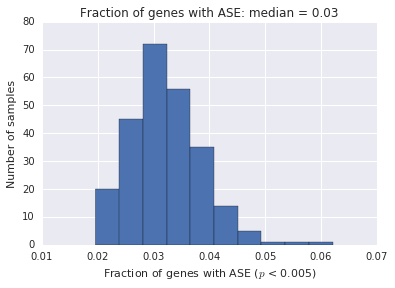

In [5]:
frac = []
for k in locus_p.keys():
    frac.append(sum(locus_p.ix[k, :, 'p_val_ase'].dropna() < 0.005) / 
                float(locus_p.ix[k, :, 'p_val_ase'].dropna().shape[0]))

plt.hist(frac)
plt.title('Fraction of genes with ASE: median = {:.2f}'.format(np.median(frac)))
plt.ylabel('Number of samples')
plt.xlabel('Fraction of genes with ASE ($p$ < 0.005)');

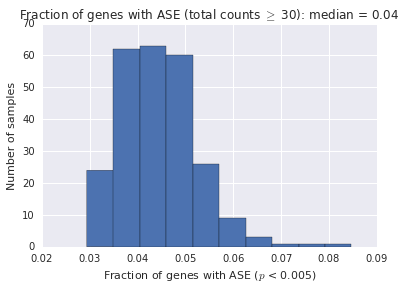

In [6]:
frac = []
for k in locus_p.keys():
    d = dict(zip(count_res[k]['feature'], count_res[k]['totalFeatureCount']))
    t = locus_p[k, :, ['major_allele_freq', 'p_val_ase']].dropna()
    t['totalFeatureCount'] = [d[i] for i in t.index]
    t = t[t.totalFeatureCount >= 30]
    frac.append(sum(t['p_val_ase'] < 0.005) / float(t.shape[0]))

plt.hist(frac)
plt.title('Fraction of genes with ASE (total counts $\geq$ 30): median = {:.2f}'.format(np.median(frac)))
plt.ylabel('Number of samples')
plt.xlabel('Fraction of genes with ASE ($p$ < 0.005)');

It seems that the fraction of genes we see ASE for agrees with GTEx. We may have a bit
more power from MBASED although our coverage is probably not quite as high.

## ASE/eQTL Enrichment 

In [7]:
df = locus_p.ix[:, :, 'p_val_ase']
df = df[meta[meta.in_eqtl].index]
df = df.ix[set(df.index) & set(qvalues.index)]

s = set(df.index) & set(qvalues[qvalues.sig_gene].index)
ns = set(df.index) & set(qvalues[qvalues.sig_gene == False].index)

t = df.ix[s]
s_s = (t[t.isnull() == False] < 0.005).sum().sum()
s_ns = (t[t.isnull() == False] >= 0.005).sum().sum()
t = df.ix[ns]
ns_s = (t[t.isnull() == False] < 0.005).sum().sum()
ns_ns = (t[t.isnull() == False] >= 0.005).sum().sum()
odds, pval = fisher_exact([[s_s, s_ns], [ns_s, ns_ns]])
print('eQTL genes enriched for ASE with p = {}, odds = {:.2f}'.format(pval, odds))

eQTL genes enriched for ASE with p = 0.0, odds = 3.01


## Clustering

I'd like to see how subjects cluster according to ASE.